In [1]:
import pandas as pd

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

import matplotlib.pyplot as plt

from copia.data import to_copia_dataset
from copia.estimators import diversity
from copia.rarefaction_extrapolation import species_accumulation
from copia.plot import accumulation_curve

More generally, I would like to see a robustness analysis on the estimator - this is an active area of research. IE use several different estimator methods and show the result is not dependent on which one is used.

At a minimum I would like to see that results don't (or possibly do which would require explanation) using Chao1 and Generalized Chao. As best I can tell more recent methods like Alroy's [2008] method for correcting for recency bias wouldn't work, but there are a lot of choices out there. This is supplemental material, but important. It would be required in my field. 

--> By robustness analysis, we understand that the reviewer requests a formal comparison of different estimators. In copia, a diverse set of alternative estimators have already been implemented (such as the jackknife): if we would bin, for instance, the producers by occupation level, we could run these on the groups in isolation and compare them the results of the Generalized Chao. [MIKE] [2h]


Formal comparison of different estimators

1) Chao1 
2) Generalized  [Already implemented]
3) Jacknife (if we would bin, for instance, the producers by occupation level, we could run these on the groups in isolation and compare them the results of the Generalized Chao.) - https://github.com/mikekestemont/copia

Copia is a statistical software package for estimating diversity and richness on the basis of abundance data. The package contains several bias-correcting richness estimators, such as the Chao1 and the Jacknife estimator.

### Testing

chao1 -> 6
ichao1 -> 6
ace -> 7
jackknife -> 6
egghe_proot -> 6


/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/copia/estimators.py:103: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

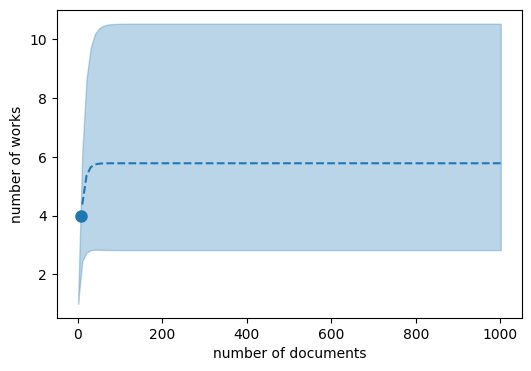

In [2]:
observations = 'duck', 'duck', 'eagle', 'dove', 'dove', 'dove', 'hawk', 'dove', 'dove'
ds = to_copia_dataset(observations, data_type="abundance", input_type="observations")

for method in ('chao1', 'ichao1', 'ace', 'jackknife', 'egghe_proot'):
    print(method, '->', round(diversity(ds, method=method)))

D = diversity(ds, method='chao1', CI=True, n_iter=100, n_jobs=1)

accumulation = species_accumulation(ds, max_steps=1000, n_iter=100, step_size=10)
fig, ax = plt.subplots(figsize=(6, 4))

accumulation_curve(
    ds, accumulation, ax=ax, xlabel="number of documents", ylabel="number of works");

#### Apply on normal data

In [3]:
df = pd.read_csv('unseen_species_model/unseen_species_model_bayesian.csv')

df["count"] = df["count_works"].copy()
df['count'] = df['count'].astype(int)
sample = df.copy()
sample = sample[sample["count"].isin({0, 1, 2})]  # Not more ?
sample["y"] = sample["count"].map({0: 0, 1: 0, 2: 1})


#sample = sample.sample(2000, random_state=42)

sample['count'][sample['count']==0] = 1

df_copia = sample[['individual_wikidata_id', 'count']].copy().drop_duplicates()
individual_counts = df_copia.set_index('individual_wikidata_id')['count']
individual_counts.index.name = None

for region in sample.region_name.unique():

    print(region)

    df_copia = sample[['individual_wikidata_id', 'count', 'region_name']].copy().drop_duplicates()
    df_copia = df_copia[df_copia['region_name']==region]
    individual_counts = df_copia.set_index('individual_wikidata_id')['count']
    individual_counts.index.name = None
    ds = to_copia_dataset(individual_counts, data_type="abundance", input_type="counts")

    method = 'jackknife'
    # method='chao1'
    res = ds.S_obs/(ds.S_obs + round(diversity(ds, method=method)))
    print(round(res, 2))
    # for method in ('chao1', 'jackknife'):
    #     print(method, '->', round(diversity(ds, method=method)))


German world
0.34
Northwestern Europe
0.34
France
0.34
Italy
0.34
Southwestern Europe
0.34
Low countries
0.34
Central Europe
0.34
Arabic world
0.34
United Kingdom
0.34
Spain
0.34
Nordic countries
0.34
East Slavic
0.34
Indian world
0.34
Persian world
0.34
Japan
0.34
Portugal
0.34
Greek World
0.34
Northern China
0.35
Chinese world
0.34
Southern Japan
0.34
Southern China
0.35
Latin World
0.35
Northern Japan
0.34
Korea
0.34


In [4]:
# Initialize results list
results = []

# Process each region separately
for region in sample['region_name'].unique():
    region_data = sample[sample['region_name'] == region]
    
    # Get min and max decades for this region
    min_decade = region_data['decade'].min()
    max_decade = region_data['decade'].max()
    
    # Create 10 equal time bins
    time_range = max_decade - min_decade
    bin_size = time_range / 10
    
    # Create custom bins
    bins = [min_decade + i * bin_size for i in range(11)]
    labels = [i for i in range(10)]
    
    # Apply the custom binning
    region_data['time_period'] = pd.cut(region_data['decade'], 
                                         bins=bins, 
                                         labels=labels, 
                                         include_lowest=True)
    
    # Group by time period and occupation
    groups = region_data.groupby(['time_period', 'occupation'])
    
    # Iterate through each group
    for (time_period, occupation), group_data in groups:
        # Get counts for unique individuals in this group
        df_unique = group_data[['individual_wikidata_id', 'count']].drop_duplicates()

        individual_counts = df_unique.set_index('individual_wikidata_id')['count']
        individual_counts.index.name = None
        ds = to_copia_dataset(individual_counts, data_type="abundance", input_type="counts")

    
        chao1 = round(diversity(ds, method='chao1'))
        jackknife =  round(diversity(ds, method='jackknife'))
        ichao1 =  round(diversity(ds, method='ichao1'))
        # ace =  round(diversity(ds, method='ace'))
        # egghe_proot=  round(diversity(ds, method='egghe_proot'))
            
        # # Calculate Chao1 statistics
        # stats = calculate_chao1(counts)
        
        # Add to results
        results.append({
            'region_name': region,
            'decade_binned': time_period,
            'occupation': occupation,
            'f1': ds.f1,
            'f2': ds.f2,
            'n': ds.n,
            'chao1': chao1,
            'jackknife':jackknife,
            'ichao1':ichao1,
            # 'ace':ace,
            # 'egghe_proot':egghe_proot

        })

# Create DataFrame from results
df_estimator = pd.DataFrame(results)

# Sort by region, time period, occupation
df_estimator = df_estimator.sort_values(['region_name', 'decade_binned', 'occupation'])

df_estimator = df_estimator.groupby(['region_name']).agg({'chao1':'sum', 
                                                  'jackknife':'sum', 
                                                  'ichao1':'sum', 
                                                #   'ace':'sum', 
                                                #   'egghe_proot':'sum',
                                                  'f1':'sum', 
                                                  'f2':'sum', 
                                                  'n':'sum'}).reset_index()

df_estimator['total_chao'] = df_estimator['chao1'] + df_estimator['f1']+ df_estimator['f2']
df_estimator['total_jackknife'] = df_estimator['jackknife'] + df_estimator['f1']+ df_estimator['f2']
df_estimator['S_obs'] = df_estimator['f1']+df_estimator['f2']

df_estimator

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_21711/2626018719.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = region_data.groupby(['time_period', 'occupation'])
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/copia/estimators.py:103: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/copia/estimators.py:103: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/copia/estimators.py:103: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4

,region_name,chao1,jackknife,ichao1,f1,f2,n,total_chao,total_jackknife,S_obs
0,Arabic world,12193,2262,12193,1120,80,1280,13393,3462,1200
1,Central Europe,454703,16377,454703,8293,205,8703,463201,24875,8498
2,Chinese world,16783,2842,16783,1376,124,1624,18283,4342,1500
3,East Slavic,147389,7588,147389,3795,122,4039,151306,11505,3917
4,France,271489,34314,271489,16710,1121,18952,289320,52145,17831
5,German world,1136905,57490,1136905,28370,957,30284,1166232,86817,29327
6,Greek World,11590,2035,11590,1040,58,1156,12688,3133,1098
7,Indian world,3234,732,3234,378,33,444,3645,1143,411
8,Italy,632629,27743,632629,13661,554,14769,646844,41958,14215
9,Japan,10524,1766,10524,886,63,1012,11473,2715,949


In [5]:
df_estimator['detection_ratio_chao']=df_estimator['S_obs']/df_estimator['total_chao']
df_estimator['detection_ratio_jackknife']=df_estimator['S_obs']/df_estimator['total_jackknife']
df_estimator

,region_name,chao1,jackknife,ichao1,f1,f2,n,total_chao,total_jackknife,S_obs,detection_ratio_chao,detection_ratio_jackknife
0,Arabic world,12193,2262,12193,1120,80,1280,13393,3462,1200,0.09,0.35
1,Central Europe,454703,16377,454703,8293,205,8703,463201,24875,8498,0.02,0.34
2,Chinese world,16783,2842,16783,1376,124,1624,18283,4342,1500,0.08,0.35
3,East Slavic,147389,7588,147389,3795,122,4039,151306,11505,3917,0.03,0.34
4,France,271489,34314,271489,16710,1121,18952,289320,52145,17831,0.06,0.34
5,German world,1136905,57490,1136905,28370,957,30284,1166232,86817,29327,0.03,0.34
6,Greek World,11590,2035,11590,1040,58,1156,12688,3133,1098,0.09,0.35
7,Indian world,3234,732,3234,378,33,444,3645,1143,411,0.11,0.36
8,Italy,632629,27743,632629,13661,554,14769,646844,41958,14215,0.02,0.34
9,Japan,10524,1766,10524,886,63,1012,11473,2715,949,0.08,0.35


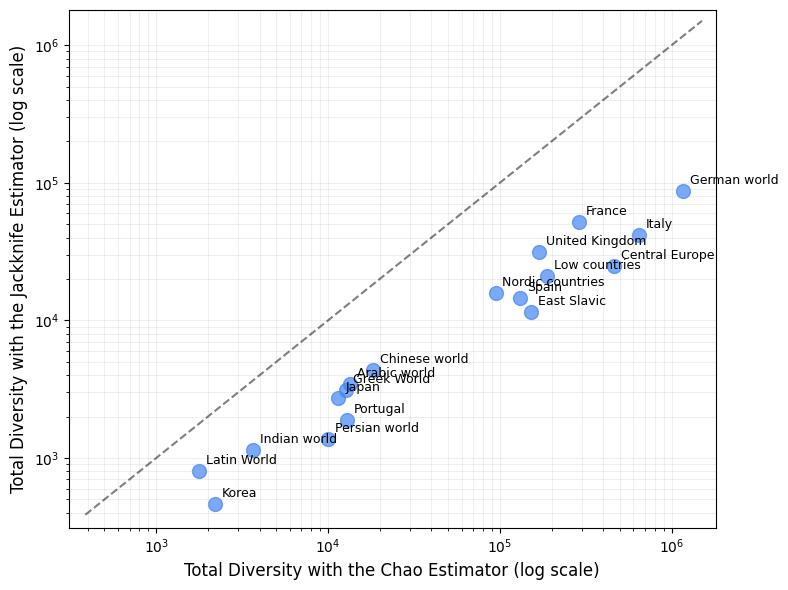

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Filter out regions with "North" and "South" in their names
main_regions = [region for region in df_estimator['region_name'] 
               if not any(direction in region for direction in ["North", "South"])]
df_main = df_estimator[df_estimator['region_name'].isin(main_regions)]

# Create a figure for the log-scale scatter plot
plt.figure(figsize=(8, 6))

# Create scatter plot with larger points
plt.scatter(df_main['total_chao'], df_main['total_jackknife'], alpha=0.7, s=100, color='#4285F4')

# Set log scales for both axes
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Total Diversity with the Chao Estimator (log scale)', fontsize=12)
plt.ylabel('Total Diversity with the Jackknife Estimator (log scale)', fontsize=12)
# No title as requested

# Add a reference line (where Chao = Jackknife)
max_val = max(df_estimator['total_chao'].max(), df_estimator['total_jackknife'].max())
min_val = min(df_estimator['total_chao'].min(), df_estimator['total_jackknife'].min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

# Add annotations for all main regions
for i, row in df_main.iterrows():
    plt.annotate(row['region_name'], 
                (row['total_chao'], row['total_jackknife']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9)

# Set axis limits with some padding
plt.xlim(min_val * 0.8, max_val * 1.2)
plt.ylim(min_val * 0.8, max_val * 1.2)

# Add grid for better readability
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

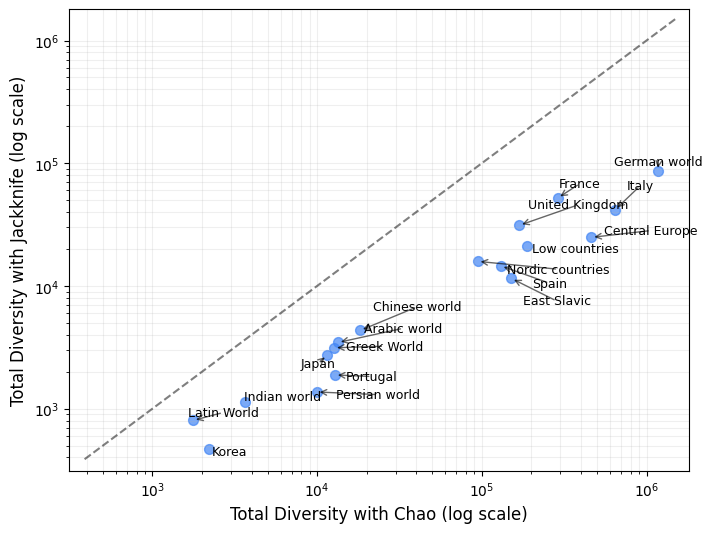

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text  # This might need to be installed with pip install adjustText

# Filter out regions with "North" and "South" in their names
main_regions = [region for region in df_estimator['region_name'] 
               if not any(direction in region for direction in ["North", "South"])]
df_main = df_estimator[df_estimator['region_name'].isin(main_regions)]

# Create a figure for the log-scale scatter plot
plt.figure(figsize=(8, 6))  # Slightly larger figure to accommodate all labels

# Create scatter plot with larger points
scatter = plt.scatter(df_main['total_chao'], df_main['total_jackknife'], alpha=0.7, s=50, color='#4285F4')

# Set log scales for both axes
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Total Diversity with Chao (log scale)', fontsize=12)
plt.ylabel('Total Diversity with Jackknife (log scale)', fontsize=12)

# Add a reference line (where Chao = Jackknife)
max_val = max(df_estimator['total_chao'].max(), df_estimator['total_jackknife'].max())
min_val = min(df_estimator['total_chao'].min(), df_estimator['total_jackknife'].min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

# Create text annotations but don't add them yet
texts = []
for i, row in df_main.iterrows():
    texts.append(plt.text(row['total_chao'], row['total_jackknife'], row['region_name'], fontsize=9))

# Use adjust_text to prevent overlap
adjust_text(texts, 
           arrowprops=dict(arrowstyle='->', color='black', alpha=0.6),
           expand_points=(1.5, 1.5),
           force_points=(0.1, 0.1))

# Set axis limits with some padding
plt.xlim(min_val * 0.8, max_val * 1.2)
plt.ylim(min_val * 0.8, max_val * 1.2)

# Add grid for better readability
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# Alternative approach if adjustText is not available:
# This manual approach uses specific positioning for problem regions

